In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import gcsfs
from xhistogram.xarray import histogram
import intake
import util
import gsw
import dask

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [23]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [24]:
cat = col.search(experiment_id=['historical'], institution_id='NCAR', table_id='Omon', member_id='r1i1p1f1', variable_id=['thetao','so','siconc'], grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
14596,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,so,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
14602,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN


In [25]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})
dset_dict.keys()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn'])

In [26]:
for i in dset_dict:
    dset_dict[i] = dset_dict[i].sel(time=slice('1986', '2005')).groupby('time.month').mean().sel(month=8)

In [27]:
for i in dset_dict:
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, dset_dict[i].so, dset_dict[i].thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    dset_dict[i] = xr.merge([cthetao, dset_dict[i]])

for i in dset_dict:    
    sigma0=xr.apply_ufunc(gsw.density.sigma0,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    dset_dict[i] = xr.merge([sigma0, dset_dict[i]])
    print(dset_dict[i])

for i in dset_dict:    
    sigma2=xr.apply_ufunc(gsw.density.sigma2,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    dset_dict[i] = xr.merge([sigma2, dset_dict[i]])
    print(dset_dict[i])

<xarray.Dataset>
Dimensions:    (d2: 2, lev: 60, member_id: 1, nlat: 384, nlon: 320, vertices: 4)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * lev        (lev) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    month      int64 8
Dimensions without coordinates: d2, vertices
Data variables:
    sigma0     (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    cthetao    (member_id, lev, nlat, nlon) float64 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32

<xarray.DataArray 'lev' (lev: 60)>
array([5.000000e+00, 1.500000e+01, 2.500000e+01, 3.500000e+01, 4.500000e+01,
       5.500000e+01, 6.500000e+01, 7.500000e+01, 8.500000e+01, 9.500000e+01,
       1.050000e+02, 1.150000e+02, 1.250000e+02, 1.350000e+02, 1.450000e+02,
       1.550000e+02, 1.650984e+02, 1.754790e+02, 1.862913e+02, 1.976603e+02,
       2.097114e+02, 2.225783e+02, 2.364088e+02, 2.513702e+02, 2.676542e+02,
       2.854837e+02, 3.051192e+02, 3.268680e+02, 3.510935e+02, 3.782276e+02,
       4.087846e+02, 4.433777e+02, 4.827367e+02, 5.277280e+02, 5.793729e+02,
       6.388626e+02, 7.075633e+02, 7.870025e+02, 8.788252e+02, 9.847059e+02,
       1.106204e+03, 1.244567e+03, 1.400497e+03, 1.573946e+03, 1.764003e+03,
       1.968944e+03, 2.186457e+03, 2.413972e+03, 2.649001e+03, 2.889385e+03,
       3.133405e+03, 3.379793e+03, 3.627670e+03, 3.876452e+03, 4.125768e+03,
       4.375392e+03, 4.625190e+03, 4.875083e+03, 5.125028e+03, 5.375000e+03])
Coordinates:
  * lev      (lev) float64 

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


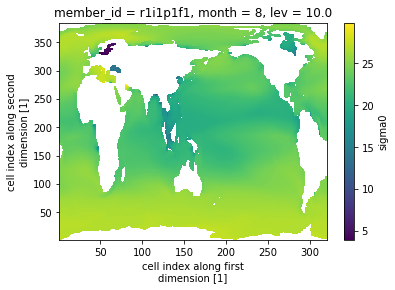

In [28]:
# need to find index of depth or lev that is closest to 10m. If units are in centimeters, convert to meters

if 'depth' in dset_dict[i]:
    dset_dict[i].depth = xr.Dataset.rename({'depth':'lev'})
    print(dset_dict[i])
if dset_dict[i].lev.units == 'centimeters':
    dset_dict[i].lev.values = dset_dict[i].lev.values/100
    dset_dict[i].lev.attrs['units'] = 'm'
    print(dset_dict[i].lev)

# interpolate density data
for i in dset_dict:
    dsi = dset_dict[i].sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
#     print(surf_dens)
surf_dens.plot()

In [29]:
for i in dset_dict:
    dens_diff = dset_dict[i].sigma0 - surf_dens
#     print(dens_diff.isel(time=0).min().values)
    dens_diff = dens_diff.where(dens_diff > 0.03)
#     print(dens_diff.shape)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


ValueError: zero-size array to reduction operation fmax which has no identity

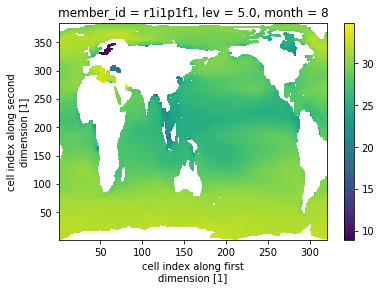

In [30]:
for i in dset_dict:
    # find depth of bottom
    test = dset_dict[i].sigma0 + dset_dict[i].lev
    test.isel(lev=0).plot()
    bottom_depth = dset_dict[i].lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    
#bottom_depth.plot()

    #relative_depth = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    #bottom_sigma2 = dset_dict[i].sigma2.where(test == test.max(['lev'])).max(dim='lev')